# TCR/CAR antagonism model for B16 and E2aPBX tumors, with comparison to mouse *in vivo* results. 
This notebook generates the model curves plotted in figure 4A. 

Then, we check how the model outputs compare against in vivo survival. The fit is not great, since in vivo processes are much more complicated than just receptor interactions, yet the model is not completely off either, suggesting that early antigen recognition results have something to say about longer time scales of the CAR response. These results are not in the article, but are presented in my (FXPB) PhD thesis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json, h5py
import os
import scipy as sp
import sys
if not "../" in sys.path:
    sys.path.insert(1, "../")

import warnings

In [2]:
from models.tcr_car_akpr_model import (
    activation_function, steady_akpr_i_receptor_types, steady_akpr_i_1ligand
)
from mcmc.costs_tcr_car_antagonism import (
    repackage_tcr_car_params, 
    antag_ratio_panel_tcr_car
)
from mcmc.prediction_utilities_tcr_car import find_1itam_car_ampli, find_1itam_effect_tcr_ampli

from utils.export import dict_to_hdf5
from mcmc.utilities_tcr_car_antagonism import load_tcr_car_molec_numbers_ci
from mcmc.ci_predictions_molec_numbers import (
    confidence_predictions_car_antagonism, 
    compute_stats_ci
)   

In [3]:
# Parameters to change to True if you want to save figures and outputs
do_save_plots = False
do_save_outputs = False

# Number of samples for model CI, 1000 should be good. 
n_boot = 1000

In [4]:
# Aesthetic parameters
plt.rcParams['figure.dpi'] = 150 # default for me was 75
fig_dir = os.path.join("..", "figures", "invivo")
data_surf = os.path.join("..", "data", "surface_counts")
data_dir = os.path.join("..", "data", "invivo/")
res_folder = os.path.join("..", "results", "for_plots")
mcmc_folder = os.path.join("..", "results", "mcmc")
plt.rcParams["font.family"] = "Arial"

## Model parameters
Fitted values on TCR-TCR antagonism, then CAR-TCR antagonism. 

*Use $(k, m, f) = (1, 4, 1)$* for the TCR and the best kmf fit for the CAR. 

In [5]:
with open(os.path.join("..", "data", "pep_tau_map_ot1.json"), "r") as handle:
    pep_tau_map = json.load(handle)

In [6]:
# Load best parameter fit
fit_conc = ["1uM", "1nM"]
analysis_res_fname = "mcmc_analysis_tcr_car_both_conc.json"
with open(os.path.join(mcmc_folder, analysis_res_fname), "r") as jfile:
    all_results_dicts = json.load(jfile)
    del jfile

# Find best kmf
#best_kmf_string, pvec_best, best_cost = find_best_grid_point(all_results_dicts, strat="best")
chosen_kmf = (1, 2, 1)
best_kmf_string = str(chosen_kmf)
pvec_best = np.asarray(all_results_dicts.get(best_kmf_string).get("param_estimates").get("MAP best"))


# Load constant parameter values
samples_fname = samples_fname = "mcmc_results_tcr_car_both_conc.h5"
with h5py.File(os.path.join(mcmc_folder, samples_fname), "r") as rfile:
    data_group = rfile.get("data")
    fit_param_names = list(rfile.get("samples").attrs.get("param_names"))
    # Load samples too, for CI generation
    mcmc_samples_car = rfile.get("samples").get(best_kmf_string)[()]
    l_conc_mm_params = data_group.get("l_conc_mm_params")[()]
    cost_args_loaded = [data_group.get(a)[()]
                        for a in data_group.attrs.get("cost_args_names")]
    data_file_name = data_group.attrs.get("data_file_name")
    del data_group, rfile

# Model predictions for low Ag density
Predictions for the regime relevant to B16 tumors in their initial state in vivo. 

Also illustrate E2aPBX on the same graph. 

## B16 melanoma cells versus E2aPBX: load surface molecule numbers

In [7]:
# Need to correct B16 total molecule numbers for the larger surface area of B16
# B16 cells: 15.4 \pm 1.6 uM diameter typically, see section 3. Results, paragraph 1
#     in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6470883/
# Nalm6 cells: 11.5 \pm 0.5 uM diameter typically, see fig. 5 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3823490/
# E2aPBX cells: probably smaller even than Nalm6, can't find a reference. 
# These numbers below are eyeballed by Taisuke. 
b16_area = 10.0
nalm6_area = 5.0
e2apbx_area = 2.0
surface_factor_b16 = b16_area / e2apbx_area


# TCR Antigen numbers: H-2kb numbers
mtc = "Geometric mean"
molec_counts_filename = os.path.join(data_surf, "surface_molecule_summary_stats.h5")
molec_stats = pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")
h2kb_l_b16 = molec_stats.at[("B16", "MHC"), mtc] / surface_factor_b16
l_tcr_dict = {
    "E2aPBX": molec_stats.at[("E2aPBX_WT", "MHC"), mtc], 
    "B16-CD19": h2kb_l_b16
}

# CD19 numbers. For E2aPBX, already in cd19_tau_l loaded from cost function arguments
# For B16, average across tumor lines, so there's one CD19 number
# across TCR antigens for a nice model curve
cd19_tau_l = cost_args_loaded[3]
cd19_l_b16 = molec_stats.at[("B16", "CD19"), mtc] / surface_factor_b16
cd19_levels_dict = {
    "E2aPBX": cd19_tau_l[1], 
    "B16-CD19": cd19_l_b16
}

# Also, load uncertainties on ligand numbers
tum_molec_stds_dofs = {}
tum_names_map = {"B16-CD19":"B16", "E2aPBX":"E2aPBX_WT"}
for tum in cd19_levels_dict.keys():
    tum_molec_stds_dofs[tum] = load_tcr_car_molec_numbers_ci(
        molec_counts_filename, mtc, tumor_type=tum_names_map[tum], 
        tcell_type="OT1_CAR", tumor_antigen="CD19", data_fold="../data/", 
    )[5:]  # 5 is stds, 6 is n_dofs

# Predict in vivo growth
Do a simple regression of the growth parameter as a function of the model predictions for various. Regression on the single ligand data and interpolation for the mixtures. 

In [8]:
### Rearrange loaded parameters in the correct format 
other_rates, ritot, nmf_fixed, cd19_tau_l = cost_args_loaded
res = repackage_tcr_car_params(pvec_best, chosen_kmf, *cost_args_loaded[:3])
(
all_rates, tcr_rates, car_rates, ritot_vec, tcr_ri, car_ri,
nmf_both, tcr_nmf, car_nmf, threshold_taus
) = res

# Change default cd19_tau_l argument to B16 antigen levels
cd19_tau_l_b16 = (cd19_tau_l[0], cd19_l_b16)

# Compute thresholds
tcr_thresh = steady_akpr_i_1ligand(tcr_rates, threshold_taus[0],
        10*tcr_ri[0], tcr_ri, tcr_nmf, large_l=True)[tcr_nmf[0]]
car_thresh = steady_akpr_i_1ligand(car_rates, threshold_taus[1],
        10*car_ri[0], car_ri, car_nmf, large_l=True)[car_nmf[0]]

l_tcr_dict_growth = l_tcr_dict

## Import tumor area data

In [9]:
# Load data
B16InVivoDf = pd.read_hdf(os.path.join(data_dir, 'B16-combined_tumorMeasurements-unblinded.h5'))

#Remove JDIV-12, CAR_WT, V4, Mouse 2 (abnormally early death (3 days))
B16InVivoDf = B16InVivoDf.query("Experiment != 'JDIV-12' or (Experiment == 'JDIV-12' and Tumor != 'V4') or (Experiment == 'JDIV-12' and Tumor == 'V4' and CAR != 'CAR_WT') or (Experiment == 'JDIV-12' and Tumor == 'V4' and CAR == 'CAR_WT' and Mouse != '2')")
#Remove JDIV-6, Mock, None, Mouse 5 (abnormally early death (0 days))
#B16InVivoDf = B16InVivoDf.query("Experiment != 'JDIV-6' or (Experiment == 'JDIV-6' and Tumor != 'None') or (Experiment == 'JDIV-6' and Tumor == 'None' and CAR != 'Mock') or (Experiment == 'JDIV-6' and Tumor == 'None' and CAR == 'Mock' and Mouse != '5')")
# B16InVivoDf.to_excel(os.path.join(data_dir, 'B16-combined_tumorMeasurements-unblinded.xlsx'))

# Rename CAR_WT to CAR-WT, same for Mut
B16InVivoDf = B16InVivoDf.rename({"CAR_WT":"CAR-WT", "CAR_Mut":"CAR-Mut"}, level="CAR", axis=0)

B16InVivoDf

Tumor Area
Experiment Tumor CAR     Mouse Day             
JDIV-6     N4    CAR-WT  1     0.0        29.58
                               4.0        37.40
                               6.0        40.88
                               8.0        37.72
                               11.0       25.83
...                                         ...
JDIV-12    V4    CAR-Mut 4     13.0      103.95
                               15.0      133.40
                               17.0      152.32
                               20.0      249.78
                               22.0      262.00

[2132 rows x 1 columns]

## Find survival times


In [10]:
#@title Create survival time dataframe
plottingDf = B16InVivoDf.query("Day < 80")
survivalTimes = []
survivalTuples = []
restrictedList = []
for car in plottingDf.index.unique('CAR'):
    for tcr in plottingDf.index.unique('Tumor'):
        subsetDf = plottingDf.query("CAR == @car and Tumor == @tcr")
        maxList,datas,samples = [],[],[]
        for data in subsetDf.index.unique('Experiment'):
            for sample in subsetDf.query("Experiment == @data").index.unique('Mouse'):
                times = subsetDf.query("Experiment == @data and Mouse == @sample").index.get_level_values('Day').tolist()
                maxList.append(max(times))
                datas.append(data)
                samples.append(sample)
        for i,x in enumerate(maxList):
            survivalTimes.append(x)
            survivalTuples.append([car,tcr,datas[i],samples[i]])
        lastTime = sorted(maxList)[0]
        restrictedList.append(subsetDf.query("Day <= @lastTime"))
restrictedDf = pd.concat(restrictedList)
survivalDf = pd.DataFrame(survivalTimes,index=pd.MultiIndex.from_tuples(survivalTuples,names=['CAR','Tumor','Experiment','Mouse']),columns=['Survival Time'])
survivalDf = survivalDf.reorder_levels(['Experiment', 'Tumor', 'CAR', 'Mouse'], axis=0)

In [11]:
b16Df = survivalDf.loc[survivalDf["Survival Time"] > 0.0].sort_index().copy()
b16Df

Survival Time
Experiment Tumor CAR     Mouse               
JDIV-12    N4    CAR-Mut 1               45.0
                         2               43.0
                         3               38.0
                         4               45.0
                 CAR-WT  1               48.0
...                                       ...
JDIV-9     V4    Mock    4               27.0
                 None    1               27.0
                         2               29.0
                         3               22.0
                         4               17.0

[139 rows x 1 columns]

## Compute model output for each condition

In [12]:
# Compute model output Z_tot for all conditions
# Basically 12 combinations: 
#( 'JDIV-9',   'N4', 'CAR-Mut', 'Tumor Area'),
#( 'JDIV-9',   'N4',  'CAR-WT', 'Tumor Area'),
#( 'JDIV-9',   'N4',    'Mock', 'Tumor Area'),
#( 'JDIV-9',   'N4',    'None', 'Tumor Area'),
#( 'JDIV-9', 'None', 'CAR-Mut', 'Tumor Area'),
#( 'JDIV-9', 'None',  'CAR-WT', 'Tumor Area'),
#( 'JDIV-9', 'None',    'Mock', 'Tumor Area'),
#( 'JDIV-9', 'None',    'None', 'Tumor Area'),
#( 'JDIV-9',   'V4', 'CAR-Mut', 'Tumor Area'),
#( 'JDIV-9',   'V4',  'CAR-WT', 'Tumor Area'),
#( 'JDIV-9',   'V4',    'Mock', 'Tumor Area'),
#( 'JDIV-9',   'V4',    'None', 'Tumor Area'),
# First, start without 1-ITAM CAR. 

# Define L, tau, and CAR version for each condition
# Store equivalences in a DataFrame
# Use L after MHC upregulation
idx_model_table = pd.MultiIndex.from_tuples(b16Df.groupby(["Tumor", "CAR"]).groups.keys(), 
                                      names=["Tumor", "CAR"])
col_model_table = pd.Index(["L_TCR", "tau_TCR", "L_CAR", "tau_CAR", "CAR_ITAMs", 
                           "T_N", "C_N", "Z_T", "Z_C", "Z_tot"], 
                           name="Variable model")
model_table = pd.DataFrame(np.zeros([idx_model_table.size, col_model_table.size]), 
                          index=idx_model_table, columns=col_model_table)

# Special parameters for 1-ITAM CAR
# Change n, m, f to 1, 1, 1
nmf_both_1 = [a.copy() for a in nmf_both]
for i in range(len(nmf_both_1)):
    nmf_both_1[i][1] = 1
car_nmf_1 = (1, 1, 1)
# Compute CAR threshold with nmf = 111
car_thresh_1 = steady_akpr_i_1ligand(car_rates, threshold_taus[1],
        10*car_ri[0], car_ri, car_nmf_1, large_l=True)[car_nmf_1[0]]
# Lower amplitude of Z^C for 1-ITAM CAR by a factor estimated on separate data
df_cyto_cd19only = (pd.read_hdf(data_file_name)
                    .xs("None", level="TCR_Antigen")
                    .xs("CD19", level="CAR_Antigen"))
car_ampli_1, _ = find_1itam_car_ampli(df_cyto_cd19only, pvec_best, chosen_kmf, *cost_args_loaded)

# Also lower TCR ampli
# Also determine impact of 1-ITAM CAR on TCR response amplitude
df_cyto_tcronly = (pd.read_hdf(data_file_name)
                    .xs("None", level="CAR_Antigen"))
tcr_ampli_factor, _ = find_1itam_effect_tcr_ampli(df_cyto_tcronly)

# Compute model output for each condition in the table
for idx in idx_model_table:
    tau_tcr = pep_tau_map.get(idx[0])
    l_tcr = 0.0 if idx[1] == "None" else l_tcr_dict["B16-CD19"]
    # Assume no CAR stimulation at all in the absence of CD19 tumors
    tau_car = cd19_tau_l_b16[0] if idx[1].startswith("CAR") else 1.0  # Avoid zerodivisionerror
    l_car = cd19_tau_l_b16[1] if idx[1].startswith("CAR") else 0.0
    car_itams = 1 if idx[1] == "CAR-Mut" else 3
    model_table.loc[idx, :"CAR_ITAMs"] = (l_tcr, tau_tcr, l_car, tau_car, car_itams)
    
    # Now compute model output for this condition
    taus = np.asarray([tau_tcr, tau_car])
    lvec = np.asarray([l_tcr, l_car])
    if car_itams == 1:
        complexes_mix = steady_akpr_i_receptor_types(all_rates, taus, lvec, ritot_vec, nmf_both_1)
        model_table.loc[idx, "Z_C"] = car_ampli_1 * activation_function(complexes_mix[1][-1], car_thresh_1)
        model_table.loc[idx, "Z_T"] = tcr_ampli_factor * activation_function(complexes_mix[0][-1], tcr_thresh)
    else:
        complexes_mix = steady_akpr_i_receptor_types(all_rates, taus, lvec, ritot_vec, nmf_both)
        model_table.loc[idx, "Z_C"] = activation_function(complexes_mix[1][-1], car_thresh)
        model_table.loc[idx, "Z_T"] = activation_function(complexes_mix[0][-1], tcr_thresh)
    model_table.loc[idx, "Z_tot"] = model_table.loc[idx, "Z_T":"Z_C"].sum()

# Use the model table to associate a model prediction to each experimental data point
dataModelDfB16 = b16Df.copy()
dataModelDfB16["Z_tot"] = np.zeros(b16Df.shape[0])
for idx in dataModelDfB16.index:
    model_idx = idx[1:3]  # Tumor, CAR
    dataModelDfB16.loc[idx, "Z_tot"] = model_table.loc[model_idx, "Z_tot"]

# Clipped version of Z_tot, for log scale
dataModelDfB16["Z_tot_clip"] = dataModelDfB16["Z_tot"].clip(0.05, np.inf)

# Drop the mouse that survived 0 days, this is a fluke
dataModelDfB16 = dataModelDfB16.loc[dataModelDfB16["Survival Time"] > 0.0]

In [13]:
model_table

Variable model      L_TCR   tau_TCR          L_CAR  tau_CAR  CAR_ITAMs  T_N  \
Tumor CAR                                                                     
N4    CAR-Mut   96.855319  10.00000  157577.331358    500.0        1.0  0.0   
      CAR-WT    96.855319  10.00000  157577.331358    500.0        3.0  0.0   
      Mock      96.855319  10.00000       0.000000      1.0        3.0  0.0   
      None       0.000000  10.00000       0.000000      1.0        3.0  0.0   
None  CAR-Mut   96.855319   0.00100  157577.331358    500.0        1.0  0.0   
      CAR-WT    96.855319   0.00100  157577.331358    500.0        3.0  0.0   
      Mock      96.855319   0.00100       0.000000      1.0        3.0  0.0   
      None       0.000000   0.00100       0.000000      1.0        3.0  0.0   
V4    CAR-Mut   96.855319   2.89429  157577.331358    500.0        1.0  0.0   
      CAR-WT    96.855319   2.89429  157577.331358    500.0        3.0  0.0   
      Mock      96.855319   2.89429       0.000000      1.0        3.0  0.0   
      None       0.000000   2.89429       0.000000      1.0        3.0  0.0   

Variable model  C_N           Z_T       Z_C         Z_tot  
Tumor CAR                                                  
N4    CAR-Mut   0.0  1.272682e+00  0.060274  1.332955e+00  
      CAR-WT    0.0  4.058401e-01  0.212539  6.183795e-01  
      Mock      0.0  9.151286e-01  0.000000  9.151286e-01  
      None      0.0  0.000000e+00  0.000000  0.000000e+00  
None  CAR-Mut   0.0  9.490452e-49  0.116008  1.160079e-01  
      CAR-WT    0.0  4.605111e-49  0.369225  3.692252e-01  
      Mock      0.0  5.421845e-45  0.000000  5.421845e-45  
      None      0.0  0.000000e+00  0.000000  0.000000e+00  
V4    CAR-Mut   0.0  1.490338e-04  0.080998  8.114753e-02  
      CAR-WT    0.0  4.920334e-05  0.268184  2.682332e-01  
      Mock      0.0  3.666565e-02  0.000000  3.666565e-02  
      None      0.0  0.000000e+00  0.000000  0.000000e+00

## General linear regression
Survival time as a function of model output. Just show there is a good correlation. 

In [14]:
# Confidence interval and prediction interval for linear regression
# See Scott, 2020, Statistics: A Concise Mathematical Introduction for Students, Scientists, and Engineers
# section 8.5. The intervals are based on the assumption that y follows a normal 
# distribution at X=x, with mean mx+b, 
# hence y-(mx+b) / (variance estimator) follows a Student-t distribution. 

# There is a difference between predicting the mean and its estimation error (confidence interval)
# and predicting an actual new sampled value of y at X=x (prediction interval). 
# For the regression on model output vs survival, the relevant interval is the confidence interval; 
# For the prediction of survival in new conditions, the relevant interval is the prediction interval. 

# 95 % confidence interval for Student-t: alpha=0.05, t_crit = value of T for which cdf is 1-alpha/2. 
# Inverse of cdf: ppf (Percent point function)

# And now a function to return the confidence interval on the regression mean at each x on a range
# Return the upper and lower y limits
# This was already available in statsmodel but I wanted to understand: 
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.conf_int.html
def student_t_confid_interval_linregress(x, alpha, ndf, mean_x_estim, vari_estim, ssx, slope, intercept):
    r""" Compute the confidence interval (upper and lower y values) 
    of a linear regression at values x. This gives the region in which there 
    is a probability (1-alpha) to find the true mean of the linear regression. 
    
    Args:
        x (np.ndarray): values of X at which the interval will be evaluated
        alpha (float): 1 - confidence level (e.g. alpha=0.05 for 95 % ci)
        ndf (int): number of degrees of freedom = nb data points - nb parameters
        mean_x_estim (float): sample mean of X values on which the regression 
            was performed, i.e. x_bar = 1/n_pts \sum_i x_i
        vari_estim (float): sample variance of residuals, 
            \sum_i (y_i - (mx_i +b))**2 / (n_pts-2)
        ssx (float): \sum_i (x_i - mean_x_estim)**2
        slope (float): slope of the regression, i.e., m in mx + b
        intercept (float): y-axis intercet of the regression, i.e., b in mx + b
    
    Returns:
        y_lo (np.ndarray): lower y values of the confidence interval at each x
        y_up (np.ndarray): upper y values of the confidence interval at each x
    """
    t_crit = sp.stats.t.ppf(q=1.0 - alpha/2.0, df=ndf-2)
    abs_range = t_crit * np.sqrt(vari_estim * (1.0/ndf + (x - mean_x_estim)**2/ssx))
    return abs_range

def student_t_predict_interval_linregress(x, alpha, ndf, mean_x_estim, vari_estim, ssx, slope, intercept):
    r""" Compute the prediction interval (upper and lower y values) 
    of a linear regression at values x. This is larger than the confidence interval;
    it gives the region in which there is a probability (1-alpha) to find a new
    value not included in the regression fit. 
    
    Args:
        x (np.ndarray): values of X at which the interval will be evaluated
        alpha (float): 1 - confidence level (e.g. alpha=0.05 for 95 % ci)
        ndf (int): number of degrees of freedom = nb data points - nb parameters
        mean_x_estim (float): sample mean of X values on which the regression 
            was performed, i.e. x_bar = 1/n_pts \sum_i x_i
        vari_estim (float): sample variance of residuals, 
            \sum_i (y_i - (mx_i +b))**2 / (n_pts-2)
        ssx (float): \sum_i (x_i - mean_x_estim)**2
        slope (float): slope of the regression, i.e., m in mx + b
        intercept (float): y-axis intercet of the regression, i.e., b in mx + b
    
    Returns:
        y_lo (np.ndarray): lower y values of the prediction interval at each x
        y_up (np.ndarray): upper y values of the prediction interval at each x
    """
    t_crit = sp.stats.t.ppf(q=1.0 - alpha/2.0, df=ndf-2)
    abs_range = t_crit * np.sqrt(vari_estim * (1.0 + 1.0/ndf + (x - mean_x_estim)**2/ssx))
    return abs_range

# TODO: Since the residuals are most likely not normally-distributed, 
# bootstrapping or MCMC would be more appropriate methods of computing the confidence interval. 

In [15]:
def full_regression_plot(regDf, reg, confid_data, logx=False, logy=False):
    # Plotting tumor growth vs model total output for a subset of conditions
    # confid_data contains n_df, confid_alpha, x_bar, sum_xi_barx, resid_vari_estim
    p = confid_data
    plotDf = regDf.copy()
    medianDf = plotDf.groupby(["Tumor", "CAR"]).median()

    # Choose correct features depending if log or not
    x_reg_lbl = "log_Z_tot" if logx else "Z_tot"  # x quantity entering ax+b (may be log)
    x_plot_lbl = "Z_tot_clip" if logx else "Z_tot"  # x quantity to plot
    y_reg_lbl = "log_time" if logy else "Survival Time"
    y_plot_lbl = "Survival Time"
    plotDf = plotDf.loc[:, [x_plot_lbl, y_plot_lbl]]
    
    # Avoid taking log of zeros
    if logy and logx:
        print(plotDf.columns)
        meanDf = np.exp(np.log(plotDf).groupby(["Tumor", "CAR"]).mean())
    elif logy:
        meanDf = plotDf.groupby(["Tumor", "CAR"]).mean()  # For x
        meanDf[y_plot_lbl] = np.exp(np.log(plotDf[y_plot_lbl]).groupby(["Tumor", "CAR"]).mean())
    elif logx:
        meanDf = plotDf.groupby(["Tumor", "CAR"]).mean()  # For y
        meanDf[x_plot_lbl] = np.exp(np.log(plotDf[x_plot_lbl]).groupby(["Tumor", "CAR"]).mean())
    else:
        meanDf = plotDf.groupby(["Tumor", "CAR"]).mean()

    # Compute interval of confidence and of prediction
    xrange = np.linspace(regDf[x_reg_lbl].min(), regDf[x_reg_lbl].max(), 201)
    yrange = xrange * reg.slope + reg.intercept
    if logy:
        yrange = np.exp(yrange)
    # Also show confidence intervals and prediction intervals
    confid = student_t_confid_interval_linregress(xrange, p["confid_alpha"], p["n_df"], p["x_bar"], 
                                    p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)
    pred = student_t_predict_interval_linregress(xrange, p["confid_alpha"], p["n_df"], 
                                    p["x_bar"], p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)
    y_lower = reg.slope*xrange + reg.intercept - confid
    y_upper = y_lower + 2*confid
    y_lower_pred = reg.slope*xrange + reg.intercept - pred
    y_upper_pred = y_lower_pred + 2*pred
    fig, ax = plt.subplots()
    fig.set_size_inches(4., 3.5)
    
    if logx:
        xrange = np.exp(xrange)
    if logy:
        y_lower, y_upper = np.exp(y_lower), np.exp(y_upper)
        y_lower_pred, y_upper_pred = np.exp(y_lower_pred), np.exp(y_upper_pred)
    ax.fill_between(xrange, y_lower, y_upper, alpha=0.2, color="k")
    ax.fill_between(xrange, y_lower_pred, y_upper_pred, alpha=0.2, color="grey")
    marker_map = {"None":"X", "Mock":"^", "CAR-WT":"o", "CAR-Mut":"s"}
    
    g = sns.scatterplot(data=plotDf.reset_index(), x=x_plot_lbl, y=y_plot_lbl, 
                hue="Tumor", palette={"None":"g", "N4":"r", "V4":"b"}, 
               style="CAR", markers=marker_map, figure=fig, ax=ax, alpha=0.75, edgecolors=None)
    # Annotate with log-scale means
    g = sns.scatterplot(data=meanDf.reset_index(), x=x_plot_lbl, y=y_plot_lbl, 
                       hue="Tumor", palette={"None":"g", "N4":"r", "V4":"b"}, 
                       marker="_", figure=fig, ax=ax, s=10**2, legend=False)
    g.plot(xrange, yrange, ls="-", color="k", lw=1.0)
    g.annotate(r"$R^2 = {:.4f}$".format(reg.rvalue**2), xy=(0.05, 70), ha="left", va="center")

    g.set(xlabel=r"Model output $Z_{tot}$", ylabel="Survival time (d)")
    if logx:
        g.set_xscale("log")
    if logy:
        g.set_yscale("log")
        g.set_ylim((9.5, 105))
    # Move legend only available in more recent seaborn versions
    #sns.move_legend(g, "upper left", bbox_to_anchor=(0.3, 0.9))
    handles, labels = g.get_legend_handles_labels()
    # TODO: Add patches to illustrate the two confidence interval types
    leg = g.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
    return fig, ax, leg

Slope: 0.30937821377931074 pm 0.025833675275981936
Intercept: 4.029852584080685
Index(['Z_tot_clip', 'Survival Time'], dtype='object')


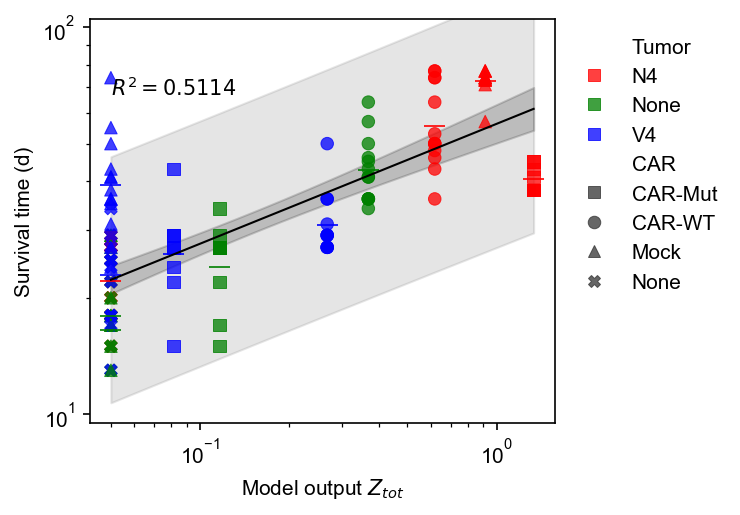

In [16]:
# log-log regression
dataModelDfB16["log_Z_tot"] = np.log(dataModelDfB16["Z_tot_clip"])
dataModelDfB16["log_time"] = np.log(dataModelDfB16["Survival Time"])

x = dataModelDfB16["log_Z_tot"].values
y = dataModelDfB16["log_time"].values
reg_loglog = sp.stats.linregress(x, y)
print("Slope: {0.slope} pm {0.stderr}".format(reg_loglog))
print("Intercept: {0.intercept}".format(reg_loglog))


# Confidence interval parameters
# Confidence interval on Y (the regression line, i.e. the mean) at X=x: from Scott, 2020, eq. 8.44, 
# Y = (\hat{y} - y) / sqrt(\hat{sigma}_epsilon^2 (1/n + (x-\bar{x})^2/(\sum_i x_i - \bar{x})^2))
# Variance estimate \hat{\sigma}_\epsilon^2, first:
# Also need \sum_i (x_i - \bar{x})^2
n_degf = dataModelDfB16.shape[0]
x_bar = np.mean(x)
confidence_dict_loglog = {
    "confid_alpha": 0.05, 
    #"t_crit_alpha" : sp.stats.t.ppf(q=1.0 - confid_alpha/2, df=n_df-2),
    "n_df": n_degf,
    "resid_vari_estim": np.sum((y - reg_loglog.slope*x - reg_loglog.intercept)**2) / (n_degf-2), 
    "x_bar":  x_bar,
    "sum_xi_barx": np.sum((x - x_bar)**2)
}
# (regDf, reg, confid_data, logx=False, logy=False)
fig, ax, leg = full_regression_plot(dataModelDfB16, reg_loglog, confidence_dict_loglog, logx=True, logy=True)
if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "linear_regression_survival_ztot.pdf"), transparent=True, 
            bbox_inches="tight", bbox_extra_artists=(leg,))
plt.show()
plt.close()

# Regression on single antigen conditions, prediction of mixtures
Regression on data where the cells effectively see a single antigen. Prediction of antigen mixtures for both CAR-T types. 

Choice of regression: linear model, linear survival. 

log model, linear survival was OK too, better spread of conditions when using higher Ag densities, anyways. 

In [17]:
# Model output for each available exp. condition already computed separately. 
# Will do linear regression of survival as a function of pre-computed Z_tot
# on single antigen data. 
# List of (tumor, CAR) tuples where T cells have effectively 0 or 1 antigen to see. 
dataModelDfB16 = dataModelDfB16.reorder_levels(["Tumor", "CAR", "Experiment", "Mouse"])
dataModelDfB16 = dataModelDfB16.sort_index()
list_singleAg = [
    ("None", "None"), 
    ("N4", "None"), 
    ("V4", "None"), 
    ("None", "Mock"),
    ("N4", "Mock"), 
    ("V4", "Mock"),
    ("None", "CAR-WT"), 
    ("None", "CAR-Mut")
]
singleAgDf = pd.concat({k:dataModelDfB16.loc[k] for k in list_singleAg}, names=["Tumor", "CAR"])
#singleAgDf = dataModelDfB16.loc[list_singleAg]

# Then predict dual-antigen data from the model Z_tot plus the regression
# Get the mixtures in a separate Df
list_mixAg = [
    ("N4", "CAR-WT"), 
    ("V4", "CAR-WT"), 
    ("N4", "CAR-Mut"), 
    ("V4", "CAR-Mut")
]
mixAgDf = pd.concat({k:dataModelDfB16.loc[k] for k in list_mixAg}, names=["Tumor", "CAR"])

assert ((mixAgDf.shape[0] + singleAgDf.shape[0]) == dataModelDfB16.shape[0]), "Forgot some conditions"

In [18]:
# Use the single Ag data for regression
x = singleAgDf["Z_tot"].values
y = singleAgDf["Survival Time"].values
reg_single = sp.stats.linregress(x, y)
print("Slope: {0.slope} pm {0.stderr}".format(reg_single))
print("Intercept: {0.intercept}".format(reg_single))

# Confidence interval parameters
n_degf = singleAgDf.shape[0]
x_bar = np.mean(x)
confid_dict_single = {
    "confid_alpha": 0.05, 
    #"t_crit_alpha" : sp.stats.t.ppf(q=1.0 - confid_alpha/2, df=n_df-2),
    "n_df": n_degf,
    "resid_vari_estim": np.sum((y - reg_single.slope*x - reg_single.intercept)**2) / (n_degf-2), 
    "x_bar":  x_bar,
    "sum_xi_barx": np.sum((x - x_bar)**2)
}

Slope: 53.82259495039378 pm 3.189911257736004
Intercept: 23.78306306023829


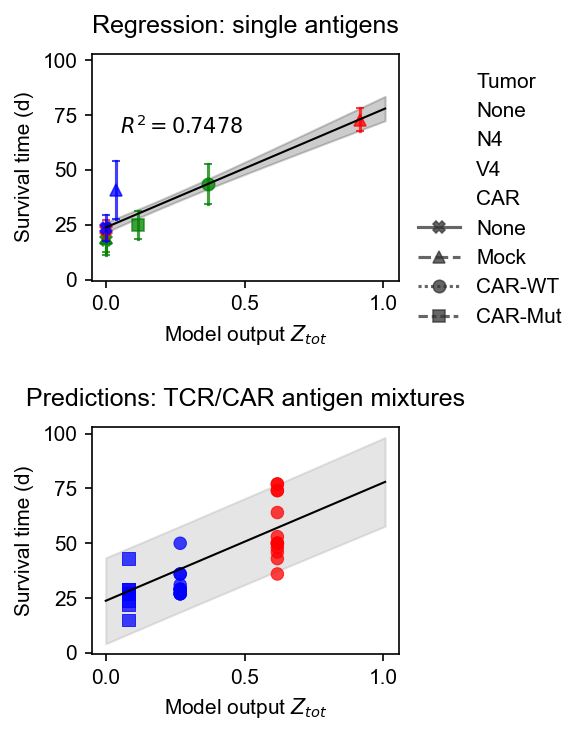

In [19]:
# Two plots. Top: regression on single Ag on top 
# (plotted as mean +- std, add in small data points later)
# Bottom: prediction: regression line with prediction interval
# and data for predicted ones later. 
# Show data as individual dots, or again mean and error bar? 
fig, axes = plt.subplots(2, 1, sharey=True)
fig.set_size_inches(4.0, 5.0)
axes = axes.flatten()

## Regression part
p = confid_dict_single
reg = reg_single
meanDf = singleAgDf.groupby(["Tumor", "CAR"]).mean()

# Compute interval of confidence and of prediction
#x_reg_lbl = "log_Z_tot" # x quantity entering ax+b (may be log)
#x_plot_lbl = "Z_tot_clip" # x quantity to plot
x_reg_lbl = "Z_tot"
x_plot_lbl = "Z_tot"
y_reg_lbl = "Survival Time"
y_plot_lbl = "Survival Time"
xrange = np.linspace(singleAgDf[x_reg_lbl].min(), singleAgDf[x_reg_lbl].max()*1.1, 201)
yrange = xrange * reg.slope + reg.intercept

# Confidence intervals for fit
confid = student_t_confid_interval_linregress(xrange, p["confid_alpha"], p["n_df"], p["x_bar"], 
                                p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)
pred = student_t_predict_interval_linregress(xrange, p["confid_alpha"], p["n_df"], 
                                p["x_bar"], p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)
y_lower = reg.slope*xrange + reg.intercept - confid
y_upper = y_lower + 2*confid
y_lower_pred = reg.slope*xrange + reg.intercept - pred
y_upper_pred = y_lower_pred + 2*pred

# Plotting
#xrange_plot = np.exp(xrange)
xrange_plot = xrange
ax = axes[0]
ax.fill_between(xrange_plot, y_lower, y_upper, alpha=0.2, color="k")

# Plot data as mean plus std: errorbar
markers = {"None":"X", "Mock":"^", "CAR-WT":"o", "CAR-Mut":"s"}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = sns.lineplot(data=singleAgDf.reset_index(), x=x_plot_lbl, y=y_plot_lbl, 
        hue="Tumor", palette={"None":"g", "N4":"r", "V4":"b"}, ms=6,
        errorbar="sd", err_style="bars", err_kws=dict(capsize=2.0), style="CAR", 
        markers=markers, linestyle='', figure=fig, ax=axes[0], alpha=0.75, 
        mec=None)

ax.plot(xrange_plot, yrange, ls="-", color="k", lw=1.0)
ax.annotate(r"$R^2 = {:.4f}$".format(reg.rvalue**2), xy=(0.05, 70), ha="left", va="center")
ax.set_title("Regression: single antigens", pad=10.0)
g.set(xlabel=r"Model output $Z_{tot}$", ylabel="Survival time (d)")
#g.set_xscale("log")

# Move legend only available in more recent seaborn versions
#sns.move_legend(g, "upper left", bbox_to_anchor=(0.3, 0.9))
handles, labels = g.get_legend_handles_labels()
# TODO: Add patches to illustrate the two confidence interval types
leg = g.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)



### Predictions
ax = axes[1]
ax.fill_between(xrange_plot, y_lower_pred, y_upper_pred, alpha=0.2, color="grey")
#g = sns.lineplot(data=singleAgDf.reset_index(), x=x_plot_lbl, y=y_plot_lbl, 
#        hue="Tumor", palette={"None":"g", "N4":"r", "V4":"b"}, ms=8,
#        ci="sd", err_style="bars", err_kws=dict(capsize=2.0), style="CAR", 
#        markers=True, linestyle='', figure=fig, ax=axes[1], alpha=0.75)
# TODO: fix style to match that in previous plot!
g = sns.scatterplot(data=mixAgDf.reset_index(), x=x_plot_lbl, y=y_plot_lbl, 
                hue="Tumor", palette={"None":"g", "N4":"r", "V4":"b"}, 
                style="CAR", figure=fig, ax=ax, alpha=0.75, edgecolor=None, 
                legend=False, markers=markers)
    
ax.plot(xrange_plot, yrange, ls="-", color="k", lw=1.0)
#ax.annotate(r"$R^2 = {:.4f}$".format(reg.rvalue**2), xy=(0.05, 70), ha="left", va="center")
ax.set_title("Predictions: TCR/CAR antigen mixtures", pad=10.0)
g.set_xlim(axes[0].get_xlim())
g.set(xlabel=r"Model output $Z_{tot}$", ylabel="Survival time (d)")
#g.set_xscale("log")

# TODO: fix legends. Show shaded area as 
# CI on mean, CI on prediction. Fix markers, lines, etc. 
# Might have to plot everything by hand in the end. 

# Move legend only available in more recent seaborn versions
#sns.move_legend(g, "upper left", bbox_to_anchor=(0.3, 0.9))
handles, labels = g.get_legend_handles_labels()
# TODO: Add patches to illustrate the two confidence interval types
#leg = g.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)

fig.tight_layout(h_pad=2.0)
if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "prediction_regression_b16.pdf"), 
                transparent=True, bbox_inches="tight")
plt.show()
plt.close()

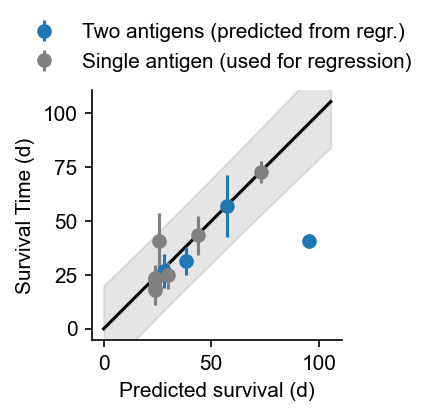

In [20]:
# Try a different kind of prediction plot: model prediction vs actual survival. 
# Grey out data used for fitting, put arrows to show antagonism. 
# Confidence interval is still a fill_between 
fig, ax = plt.subplots()
fig.set_size_inches(2.75, 2.5)
# x axis = mean survival predicted from the model for a given point
# y axis = experimental values
# Prediction interval: range of experimental values which are within the
# predicted variance around y_model. In other words, y axis values in which a data point can fall
# when its mean is predicted to be the x value. 
# So the prediction interval is on either 
# Think of the x axis as a direct mapping between Z_out and Y_mod = m*Z_out + b, 
# i.e. x axis is just a linear transform of Z_out: Y_mod = (Z_out - b)/m. 
# So confidence interval A(Z) should still be added-subtracted around the y axis (actual survival), not the x axis
plotDf = mixAgDf.copy()
reg, p = reg_single, confid_dict_single

# First average and error bar the survival times
plotDf["Predicted Survival"] = reg_single.slope * plotDf["Z_tot"] + reg_single.intercept
plotDf = plotDf.groupby(["Tumor", "CAR"]).agg(**{
    "Survival Time": pd.NamedAgg(column="Survival Time", aggfunc="mean"),
    "Error": pd.NamedAgg(column="Survival Time", aggfunc="std"), 
    "Predicted Survival": pd.NamedAgg(column="Predicted Survival", aggfunc="mean")})

# Prediction interval
horiz_range = np.linspace(0.0, dataModelDfB16["Z_tot"].max()*reg.slope + reg.intercept+10, 201)
xrange = (horiz_range - reg.intercept)/reg.slope
pred = student_t_predict_interval_linregress(xrange, p["confid_alpha"], p["n_df"], 
                         p["x_bar"], p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)
ylo, yhi = horiz_range - pred, horiz_range + pred
ax.plot(horiz_range, horiz_range, ls="-", lw=1.5, color="k")
ax.fill_between(horiz_range, ylo, yhi, color="grey", alpha=0.2)
ax.errorbar(plotDf["Predicted Survival"], plotDf["Survival Time"], 
            yerr=plotDf["Error"], ls="None", marker="o", label="Two antigens (predicted from regr.)")


# Also show the data used for regression greyed out
plotDf = singleAgDf.copy()
plotDf["Predicted Survival"] = reg_single.slope * plotDf["Z_tot"] + reg_single.intercept
plotDf = plotDf.groupby(["Tumor", "CAR"]).agg(**{
    "Survival Time": pd.NamedAgg(column="Survival Time", aggfunc="mean"),
    "Error": pd.NamedAgg(column="Survival Time", aggfunc="std"), 
    "Predicted Survival": pd.NamedAgg(column="Predicted Survival", aggfunc="mean")})

ax.errorbar(plotDf["Predicted Survival"], plotDf["Survival Time"], yerr=plotDf["Error"], 
            ls="None", marker="o", mec="grey", mfc="grey", color="grey", label="Single antigen (used for regression)")

ax.set(xlabel="Predicted survival (d)", ylabel="Survival Time (d)")
ax.set_aspect("equal")
ax.set_ylim(*ax.get_xlim())
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
#ax.set_xlim(0, 110)
fig.set_size_inches(fig.get_size_inches()[0]*1.95, fig.get_size_inches()[1]*1.15)
legend = ax.legend(bbox_to_anchor=(0.5, 1.0), loc="lower center", frameon=False, 
                  fontsize=10)
fig.tight_layout()
if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "prediction_regression_b16_overlaid.pdf"), transparent=True, 
            bbox_inches="tight", bbox_extra_artists=(legend,))
plt.show()
plt.close()

# Also plot the regression interval: for each model value, there is a range of y values predicted. 

In [21]:
#@title Plotting functions
from matplotlib.legend_handler import HandlerBase

# For adding subtitles in legends.
# Artist class: handle, containing a string
class LegendSubtitle(object):
    def __init__(self, message, **text_properties):
        self.text = message
        self.text_props = text_properties

    def get_label(self, *args, **kwargs):
        return ""  # no label, the artist itself is the text

# Handler class, give it text properties
class LegendSubtitleHandler(HandlerBase):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mpl.text.Text(x0, y0, orig_handle.text, size=fontsize, **orig_handle.text_props)
        handlebox.add_artist(title)
        return title

#@title Different plot format to emphasize prediction-fit distinction
# Strip plots for mixtures, with data vs model predictions. 
#@title Function to produce survival prediction plots
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
def survival_prediction_stripplot(singleAgDf, mixAgDf, p, reg):
    # Two plots. Top: regression on single Ag on top 
    # (plotted as mean +- std, add in small data points later)
    # Bottom: prediction: predicted survival vs actual survival, 
    # with prediction confidence interval around the diagonal. 
    fig, axes = plt.subplots(2)
    axes = axes.flatten()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize[0]*0.65, figsize[1]*1.0)

    # Nice names
    tumor_names_map = {"None":"B16-CD19", "V4":"B16-CD19/V4", "N4":"B16-CD19/N4"}
    car_names_map = {"None":"None", "Mock":"OT-1", "CAR-WT":"OT-1/CAR\n(3 ITAMs)", "CAR-Mut":"OT-1/CAR\n(1 ITAM)"}

    ## Regression part
    meanDf = singleAgDf.groupby(["Tumor", "CAR"]).mean()

    # Compute interval of confidence and of prediction
    #x_reg_lbl = "log_Z_tot" # x quantity entering ax+b (may be log)
    #x_plot_lbl = "Z_tot_clip" # x quantity to plot
    x_reg_lbl = "Z_tot"
    x_plot_lbl = "Z_tot"
    y_reg_lbl = "Survival Time"
    y_plot_lbl = "Survival Time"
    xrange = np.linspace(singleAgDf[x_reg_lbl].min(), singleAgDf[x_reg_lbl].max(), 201)
    yrange = xrange * reg.slope + reg.intercept

    # Confidence intervals for fit
    confid = student_t_confid_interval_linregress(xrange, p["confid_alpha"], p["n_df"], p["x_bar"], 
                                    p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)
    pred = student_t_predict_interval_linregress(xrange, p["confid_alpha"], p["n_df"], 
                                    p["x_bar"], p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)
    y_lower = reg.slope*xrange + reg.intercept - confid
    y_upper = y_lower + 2*confid
    y_lower_pred = reg.slope*xrange + reg.intercept - pred
    y_upper_pred = y_lower_pred + 2*pred

    # Plotting
    #xrange_plot = np.exp(xrange)
    xrange_plot = xrange
    ax = axes[0]
    ax.fill_between(xrange_plot, y_lower, y_upper, alpha=0.2, color="k")

    # Plot data as mean plus std: errorbar
    # TODO: improve legend, etc; plot everything by hand?
    markers = {"None":"X", "Mock":"^", "CAR-WT":"o", "CAR-Mut":"s"}
    tumorpalette = {"None":"g", "N4":"r", "V4":"b"}
    tumor_order = [a for a in ["None", "V4", "N4"] if a in singleAgDf.index.get_level_values("Tumor").unique()]
    car_order = [a for a in ["None", "Mock", "CAR-WT", "CAR-Mut"] if a in singleAgDf.index.get_level_values("CAR").unique()]
    with warnings.catch_warnings():
        # ignore warning raised by pandas >= 2.0.0 in seaborn when there is a single point per hue+style
        # The float() call on length-1 series is internal to seaborn but raises a Warning/future Error
        # because pandas now prohibits calling float on length-1 Series (why add this restriction...)
        # seaborn will need to update to handle this special case differently
        # inside the lineplot, regplot, etc. functions. 
        warnings.simplefilter("ignore") 
        g = sns.lineplot(data=singleAgDf.reset_index(), x=x_plot_lbl, y=y_plot_lbl, 
            hue="Tumor", palette=tumorpalette, 
            errorbar="sd", err_style="bars", err_kws=dict(capsize=2.0), style="CAR", 
            markers=markers, linestyle='', figure=fig, ax=axes[0], alpha=0.75, 
            mec=None, legend=False)

    ax.plot(xrange_plot, yrange, ls="-", color="k", lw=1.0)
    ax.annotate(r"$R^2 = {:.4f}$".format(reg.rvalue**2), xy=(0.1, 0.9), 
                ha="left", va="center", xycoords="axes fraction")

    g.set(xlabel=r"Model output $Z_{tot}$", ylabel="Survival time (d)")


    ### Predictions
    ax = axes[1]
    # First average and error bar the survival times
    plotDf2 = mixAgDf.copy()
    plotDf2["Predicted Survival"] = reg.slope * plotDf2["Z_tot"] + reg.intercept
    plotDf2 = plotDf2.groupby(["Tumor", "CAR"]).agg(**{
        "Survival Time": pd.NamedAgg(column="Survival Time", aggfunc="mean"),
        "Error": pd.NamedAgg(column="Survival Time", aggfunc="std"), 
        "Predicted Survival": pd.NamedAgg(column="Predicted Survival", aggfunc="mean"), 
        "Z_tot": pd.NamedAgg(column="Z_tot", aggfunc="mean")})

    # Prediction interval for each predicted survival
    pred = student_t_predict_interval_linregress(plotDf2["Z_tot"], p["confid_alpha"], p["n_df"], 
                            p["x_bar"], p["resid_vari_estim"], p["sum_xi_barx"], reg.slope, reg.intercept)

    # Strip plot showing CAR alone, CAR+V4, CAR+N4 for both CAR constructs
    x1 = np.arange(0, 5, 4)  # CAR alone: at 0 and 4
    rng = np.random.default_rng(seed=0x57332930e84110710e6582886c3af56d)
    plotDf = pd.concat([singleAgDf, mixAgDf])
    plotDf = plotDf.loc[plotDf.index.isin(["CAR-WT", "CAR-Mut"], level="CAR")]
    #ax = sns.stripplot(data=plotDf.reset_index(), x="CAR", y="Survival Time", 
    #              hue="Tumor", palette=tumorpalette, ax=ax)
    # Need to do manually
    tumor_order = [a for a in ["None", "V4", "N4"] if a in plotDf.index.get_level_values("Tumor").unique()]
    car_order = [a for a in ["CAR-WT", "CAR-Mut"] if a in plotDf.index.get_level_values("CAR").unique()]
    
    model_dots_properties = dict(marker="P", label="Prediction\nfrom\nregression", 
          mfc=(0.,)*3+(0.9,), mew=1.0, mec=(1.0, 1.0, 1.0, 0.7), ls="none")
    pred_color = (0.1,)*3 + (0.2,)
    plotDf = plotDf.sort_index()
    for i, car in enumerate(car_order):
        mark = markers.get(car)
        for j, tum in enumerate(tumor_order):
            y = plotDf.loc[(tum, car), "Survival Time"]
            x = x1[i] + j + 0.075*rng.normal(size=len(y))
            ax.plot(x, y, ls="none", marker=mark, label=tum, ms=4,
                    mfc=tumorpalette[tum], mec=tumorpalette[tum], alpha=0.8)
            # Plot model predictions on top
            if tum != "None":
                modely = plotDf2.loc[(tum, car), "Predicted Survival"]
                model_interv = pred.loc[(tum, car)]
                ax.errorbar(x=x1[i]+j, y=modely, yerr=model_interv, 
                            elinewidth=5.0, ecolor=pred_color, 
                            **model_dots_properties)

    ax.set(ylabel="Survival Time (d)")
    ax.set_xticks(np.sort(np.concatenate([x1, x1+1, x1+2])))
    ax.set_xticklabels(tumor_order*2)
    
    # Second x-axis to annotate CAR type
    # https://stackoverflow.com/questions/37934242/hierarchical-axis-labeling-in-matplotlib-python
    ax2 = ax.twiny()
    ax2.spines["bottom"].set_position(("axes", -0.20))
    for side in ["top", "right"]:
        ax2.spines[side].set_visible(False)
    ax2.tick_params('both', direction='in', which='major')
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    # Major tick to separate the two types of CARs, minor to annotate each
    ax2.set_xticks([x1[0]-1, x1[0]+3, x1[1]+3])
    #ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator([x1[0]+3]))
    ax2.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    xwidth = np.diff(ax.get_xlim())/2
    ax2.xaxis.set_minor_locator(mpl.ticker.FixedLocator(x1+1))
    ax2.xaxis.set_minor_formatter(mpl.ticker.FixedFormatter(
        list(map(lambda x:car_names_map.get(x), car_order))))
    
    # Final aesthetic details
    for ax in axes:
        for side in ["top", "right"]:
            ax.spines[side].set_visible(False)

    # Manual legend for regression plot
    leg_entries = [LegendSubtitle("Tumor")]
    for tum in tumor_order:
        # Patches or round markers?
        #leg_entries.append(mpl.patches.Patch(color=tumorpalette.get(tum), label=tumor_names_map.get(tum)))
        leg_entries.append(mpl.lines.Line2D([], [], ls="none", marker="o",
                      mfc=tumorpalette.get(tum), label=tumor_names_map.get(tum),
                      mec=tumorpalette.get(tum)))
    leg_entries.append(LegendSubtitle("Treatment"))
    car_order = [a for a in ["None", "Mock", "CAR-WT", "CAR-Mut"] if a in singleAgDf.index.get_level_values("CAR").unique()]
    for car in car_order:
        leg_entries.append(mpl.lines.Line2D([0], [0], color="grey", 
                      marker=markers.get(car), ls="none", label=car_names_map.get(car)))
    g.legend(handles=leg_entries, 
              handler_map={LegendSubtitle: LegendSubtitleHandler()},
              loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
    
    # Legend for prediction plot
    leg_entries = [mpl.lines.Line2D([], [], **model_dots_properties), 
                   mpl.patches.Patch(color=pred_color, label="Prediction\ninterval")]
    ax.legend(handles=leg_entries,
              handler_map={LegendSubtitle: LegendSubtitleHandler()},
              loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
    
    # Titles
    g.set_title("Regression: single stimulation", pad=10.0, fontweight="bold")
    ax.set_title("Prediction: dual stimulation", pad=10.0, fontweight="bold")
    fig.tight_layout(h_pad=2.0)
    return fig, axes

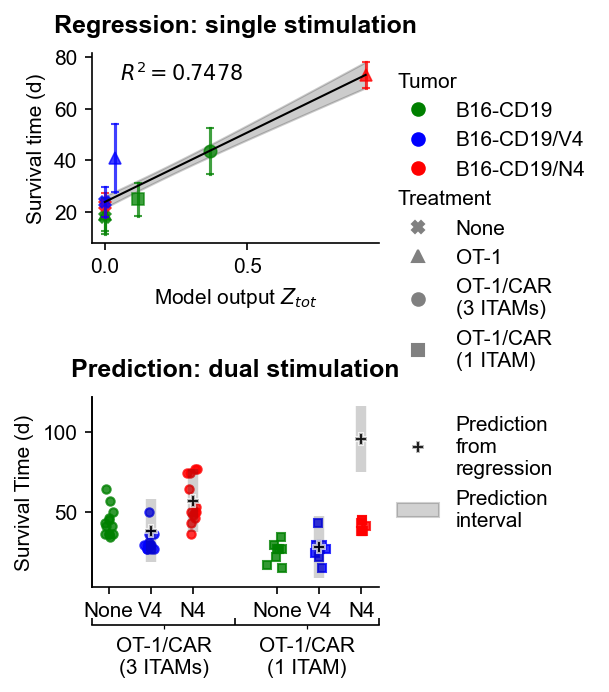

In [22]:
#@title Plot
stats_ci_b16 = confid_dict_single
reg_b16 = reg_single
fig, axes = survival_prediction_stripplot(singleAgDf, mixAgDf, stats_ci_b16, reg_b16)
if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "regression_prediction_b16_alternate.pdf"), 
            transparent=True, bbox_inches="tight")
plt.show()
plt.close()

Not too bad, there is only one condition where the prediction is really off: N4 for 1-ITAM CARs. The in vitro cytokine results (which the model fits really well -- Figure 3) did not correlate well with the in vivo results here. 